---
title: "Lab 6"
format: 
  html:
    theme: lux
---

In [3]:
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

df_hitters = pd.read_csv('/content/Hitters.csv')
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [5]:
na_cols = df_hitters.isna().any(axis=0)
na_cols = na_cols[na_cols == True]
na_cols

,0


In [6]:

dtype: bool
df_hitters.dropna(inplace=True)
df_hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


# Part I: Different Model Specs
# A. Regression without regularization

In [13]:
# Dropping 'Salary' from the features and separating the target variable
X_data = df_hitters.drop(columns=['Salary'])  # Features
y_target = df_hitters['Salary']  # Target variable

# Splitting the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_target, test_size=0.2, random_state=42)

# Column transformation: scaling numerical features and applying one-hot encoding for categorical features
column_transformer = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), make_column_selector(dtype_include=np.number)),
        ("encode", OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
)

# Creating a pipeline with the preprocessing step followed by a Linear Regression model
lr_pipeline = Pipeline([
    ("preprocessing", column_transformer),
    ("linear_regression", LinearRegression())
])

# Fitting the pipeline on the training data
lr_pipeline.fit(X_train_data, y_train_data)

def display_coefficients(model_pipeline, model_step):
    # Extracting the preprocessor and model from the pipeline using the correct step names
    preprocessor = model_pipeline.named_steps['data_preprocessing']  # Correct name for preprocessing step
    model = model_pipeline.named_steps[model_step]

    # Getting the feature names for categorical features after one-hot encoding
    categorical_features = preprocessor.named_transformers_['encode'].get_feature_names_out()

    # Getting the numerical feature names
    numerical_features = preprocessor.transformers_[0][2]
    numerical_features = X_train_data[numerical_features].columns

    # Combining both numerical and categorical feature names
    all_features = np.concatenate([numerical_features, categorical_features], axis=0)

    # Getting the model's coefficients
    model_coefficients = model.coef_

    # Creating a dictionary to map features to their coefficients
    feature_coefficient_map = dict(zip(all_features, model_coefficients))

    # Sorting the feature-coefficient mapping by the absolute value of the coefficients
    sorted_features_by_coef = sorted(feature_coefficient_map.items(), key=lambda x: abs(x[1]), reverse=True)

    # Printing the sorted features with their coefficients
    for feature, coef in sorted_features_by_coef:
        print(f"Feature: {feature}, Coefficient: {coef}")


In [14]:
# Function to compute and display Mean Squared Error (MSE) for the model
def compute_mse(model_pipeline, X_test_data, X_data, y_data, model_name):
    # Predicting on the test set
    y_predictions = model_pipeline.predict(X_test_data)

    # Calculating the MSE for the test set
    test_mse = mean_squared_error(y_test_data, y_predictions)
    print(f"MSE for {model_name} Regression on Test Set: {test_mse}")

    # Performing cross-validation and calculating MSE
    cv_scores = cross_val_score(model_pipeline, X_data, y_data, cv=5, scoring='neg_mean_squared_error')
    print(f"MSE for {model_name} Regression (Cross Validation): {-cv_scores.mean()}")

# Calling the function with the pipeline and the dataset
compute_mse(lr_pipeline, X_test_data, X_data, y_target, "Linear")


MSE for Linear Regression on Test Set: 128284.34549672349
MSE for Linear Regression (Cross Validation): 121136.31031816886


# B. Ridge regression

In [15]:
# First, define the ColumnTransformer for preprocessing
ct = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), make_column_selector(dtype_include=np.number)),
        ("encode", OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
)

# Setting up a pipeline with Ridge Regression
ridge_pipeline = Pipeline([
    ("data_preprocessing", ct),  # Using the defined ColumnTransformer here
    ("ridge_regressor", Ridge())
])

# Defining a list of potential alpha values for Ridge Regression regularization
regularization_alphas = [0.001, 0.01, 0.1, 1, 10]

# Creating a dictionary with the parameter name for the ridge step
param_grid = {'ridge_regressor__alpha': regularization_alphas}

# Performing Grid Search Cross-Validation to find the best alpha
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_data, y_target)

# Extracting and displaying the best alpha and its corresponding R-squared score
optimal_alpha = grid_search.best_params_['ridge_regressor__alpha']
optimal_score = grid_search.best_score_

print(f"Optimal alpha value: {optimal_alpha}")


Optimal alpha value: 10


In [16]:
# Setting the alpha value for Ridge regression in the pipeline
ridge_pipeline.set_params(ridge_regressor__alpha=10)

# Fitting the pipeline with the training data
ridge_pipeline.fit(X_train_data, y_train_data)

# Interpreting and displaying the coefficients of the Ridge regression model
display_coefficients(ridge_pipeline, "ridge_regressor")


Feature: Hits, Coefficient: 149.82091104712038
Feature: CRuns, Coefficient: 94.73449032868642
Feature: CRBI, Coefficient: 83.76655187097059
Feature: CHits, Coefficient: 79.85894920435442
Feature: AtBat, Coefficient: -77.2123413332791
Feature: PutOuts, Coefficient: 75.70375092323228
Feature: CWalks, Coefficient: -69.10060654644715
Feature: Walks, Coefficient: 61.51980281410101
Feature: Division_E, Coefficient: 56.88795347769234
Feature: Division_W, Coefficient: -56.88795347769203
Feature: CHmRun, Coefficient: 46.62795643890785
Feature: League_A, Coefficient: -29.048971241031627
Feature: League_N, Coefficient: 29.048971241031587
Feature: Runs, Coefficient: 17.419246223697844
Feature: Errors, Coefficient: -15.7706457183859
Feature: NewLeague_N, Coefficient: -11.734652519383799
Feature: NewLeague_A, Coefficient: 11.734652519383795
Feature: CAtBat, Coefficient: -10.664654745848777
Feature: RBI, Coefficient: 8.677162339607335
Feature: Assists, Coefficient: 8.494788725073862
Feature: Years, C

In [17]:
# Calling the function to compute MSE for the Ridge regression pipeline
compute_mse(ridge_pipeline, X_test_data, X_data, y_target, "Ridge")


MSE for Ridge Regression on Test Set: 135534.16480018946
MSE for Ridge Regression (Cross Validation): 119348.98477570349


# C. Lasso Regression


In [19]:
# Define the alpha values for regularization in Lasso regression
alpha_values = [0.001, 0.01, 0.1, 1, 10]  # Example values for alpha

# Setting up the Lasso regression pipeline
lasso_pipeline = Pipeline([
    ("data_preprocessing", ct),  # Using the defined ColumnTransformer
    ("lasso_regressor", Lasso(max_iter=10000))
])

# Defining the alpha values for regularization in Lasso regression
lasso_alphas = {'lasso_regressor__alpha': alpha_values}

# Performing Grid Search Cross-Validation to find the best alpha
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_alphas, cv=5, scoring='r2')
lasso_grid_search.fit(X_data, y_target)

# Extracting and displaying the best alpha value and corresponding R-squared score
optimal_alpha_lasso = lasso_grid_search.best_params_['lasso_regressor__alpha']
optimal_score_lasso = lasso_grid_search.best_score_

print(f"Optimal alpha value for Lasso: {optimal_alpha_lasso}")


Optimal alpha value for Lasso: 10


In [20]:
# Setting the alpha value for Lasso regression in the pipeline
lasso_pipeline.set_params(lasso_regressor__alpha=10)

# Fitting the Lasso pipeline with the training data
lasso_pipeline.fit(X_train_data, y_train_data)

# Interpreting and displaying the coefficients of the Lasso regression model
display_coefficients(lasso_pipeline, "lasso_regressor")


Feature: CRBI, Coefficient: 146.18894324216092
Feature: Hits, Coefficient: 118.19190271855959
Feature: Division_E, Coefficient: 89.09296603804802
Feature: PutOuts, Coefficient: 70.95246526643518
Feature: CRuns, Coefficient: 69.89842082523485
Feature: Walks, Coefficient: 36.774714511302335
Feature: Errors, Coefficient: -7.70484608672631
Feature: Division_W, Coefficient: -1.68100962481758e-12
Feature: AtBat, Coefficient: -0.0
Feature: HmRun, Coefficient: 0.0
Feature: Runs, Coefficient: 0.0
Feature: RBI, Coefficient: 0.0
Feature: Years, Coefficient: 0.0
Feature: CAtBat, Coefficient: 0.0
Feature: CHits, Coefficient: 0.0
Feature: CHmRun, Coefficient: 0.0
Feature: CWalks, Coefficient: -0.0
Feature: Assists, Coefficient: -0.0
Feature: League_A, Coefficient: -0.0
Feature: League_N, Coefficient: 0.0
Feature: NewLeague_A, Coefficient: -0.0
Feature: NewLeague_N, Coefficient: 0.0


In [21]:
# Calling the function to compute MSE for the Lasso regression pipeline
compute_mse(lasso_pipeline, X_test_data, X_data, y_target, "Lasso")


MSE for Lasso Regression on Test Set: 145084.5843517798
MSE for Lasso Regression (Cross Validation): 121828.10222019239


# D. Elastic Net

In [22]:
# Set up the ElasticNet regression pipeline
elastic_pipeline = Pipeline([
    ("data_preprocessing", ct),
    ("elastic_regressor", ElasticNet(max_iter=10000))
])

# Define hyperparameters for GridSearchCV
elastic_params = {
    "elastic_regressor__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic_regressor__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
}

# Perform GridSearchCV to find the best alpha and l1_ratio
elastic_grid_search = GridSearchCV(elastic_pipeline, elastic_params, cv=5, scoring='r2')
elastic_grid_search.fit(X_data, y_target)

# Extract and display the best hyperparameters
optimal_alpha_elastic = elastic_grid_search.best_params_['elastic_regressor__alpha']
optimal_l1_ratio_elastic = elastic_grid_search.best_params_['elastic_regressor__l1_ratio']
best_score_elastic = elastic_grid_search.best_score_

print(f"Optimal alpha for ElasticNet: {optimal_alpha_elastic}")
print(f"Optimal l1_ratio for ElasticNet: {optimal_l1_ratio_elastic}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.229e+06, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Optimal alpha for ElasticNet: 1
Optimal l1_ratio for ElasticNet: 0.25


In [23]:
# Set the optimal hyperparameters for the ElasticNet model
elastic_pipeline.set_params(elastic_regressor__alpha=1, elastic_regressor__l1_ratio=0.25)

# Fit the ElasticNet pipeline with the training data
elastic_pipeline.fit(X_train_data, y_train_data)

# Interpret and display the coefficients of the ElasticNet model
display_coefficients(elastic_pipeline, "elastic_regressor")


Feature: PutOuts, Coefficient: 49.01625740533098
Feature: Hits, Coefficient: 45.875974695011024
Feature: CRBI, Coefficient: 38.34601320473595
Feature: CHits, Coefficient: 37.2819868619278
Feature: CRuns, Coefficient: 36.309633550325735
Feature: Walks, Coefficient: 30.148942440012238
Feature: Runs, Coefficient: 29.414150126540704
Feature: CHmRun, Coefficient: 29.352838414479773
Feature: CAtBat, Coefficient: 28.0864463513997
Feature: Division_E, Coefficient: 26.077339187130093
Feature: Division_W, Coefficient: -26.07732952341168
Feature: RBI, Coefficient: 25.36865124698902
Feature: AtBat, Coefficient: 20.812603164464925
Feature: CWalks, Coefficient: 16.08374925819356
Feature: Years, Coefficient: 15.943003204919878
Feature: HmRun, Coefficient: 10.748095505415655
Feature: League_N, Coefficient: 7.704585209557116
Feature: League_A, Coefficient: -7.704564868155399
Feature: Errors, Coefficient: -7.418470827958747
Feature: NewLeague_N, Coefficient: 3.5600923973462
Feature: NewLeague_A, Coeffic

5 Heaviest Weighted Features (by absolute coefficient value):
1. PutOuts: 49.01625740533098
2. Hits: 45.875974695011024
3. CRBI: 38.34601320473595
4. CHits: 37.2819868619278
5. CRuns: 36.309633550325735

In [24]:
# Calling the function to compute MSE for the ElasticNet regression pipeline
compute_mse(elastic_pipeline, X_test_data, X_data, y_target, "Elastic Net")


MSE for Elastic Net Regression on Test Set: 147763.8132346431
MSE for Elastic Net Regression (Cross Validation): 121374.33335443737


# Part 2: Variable Selection
### Most important numeric variable: PutOuts
### Top five most important numeric variables: PutOuts, Hits, CRBI, CHits, CRuns
### Most important categorical variable: Division_E and Division_W (both with large absolute coefficients, though they affect the model in opposite directions).

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Define the get_mse function
def get_mse(pipeline, X_test, X, y, pipe_type):
    # Make predictions using the model
    y_pred = pipeline.predict(X_test)

    # Calculate MSE on the test set
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for {pipe_type} Regression Test Set: {mse}")

    # Perform cross-validation and calculate the average MSE
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"MSE for {pipe_type} Regression Cross Validation: {-scores.mean()}")

# Assuming the dataframe is named df_hitters or your specific dataset
X = df_hitters.drop(columns=['Salary'])  # Replace with actual features
y = df_hitters['Salary']  # Replace with actual target column

# Selecting the most important numerical feature: PutOuts
X_num = X[['PutOuts']]

# Splitting the data into training and testing sets
X_test, X_train, y_test, y_train = train_test_split(X_num, y, train_size=0.8, random_state=42)

# Defining the pipeline for Linear Regression
ct = ColumnTransformer(
    [("scalar", StandardScaler(), ['PutOuts'])],  # Only scaling the PutOuts feature
    remainder="passthrough"
)

pipeline_lr = Pipeline([
    ("preprocessing", ct),
    ("lr", LinearRegression())
])

# Fitting the pipeline with the most important feature
pipeline_lr.fit(X_train, y_train)

# Evaluating the model using MSE
get_mse(pipeline_lr, X_test, X_num, y, "Linear")


MSE for Linear Regression Test Set: 203767.53736797505
MSE for Linear Regression Cross Validation: 194266.075720736


In [34]:
# Assuming you have already defined X_num and y, and alpha_values from earlier

# Define the Ridge Regression pipeline with preprocessing
ct = ColumnTransformer(
    [("scalar", StandardScaler(), ['PutOuts'])],  # Scaling only the PutOuts feature
    remainder="passthrough"
)

pipeline_ridge = Pipeline([
    ("preprocessing", ct),
    ("ridge_regressor", Ridge())  # Using 'ridge_regressor' to match the GridSearchCV parameter
])

# Define the possible alpha values for Ridge regression
ridge_alphas = {'ridge_regressor__alpha': alpha_values}

# Perform GridSearchCV to find the best alpha
gscv_ridge = GridSearchCV(pipeline_ridge, ridge_alphas, cv=5, scoring='r2')
gscv_ridge.fit(X_num, y)

# Extract the best alpha and the corresponding score from the GridSearchCV results
optimal_alpha = gscv_ridge.best_params_['ridge_regressor__alpha']
optimal_score = gscv_ridge.best_score_

# Print the best alpha value and score
print(f"Optimal alpha: {optimal_alpha}")
print(f"Best R2 score: {optimal_score}")


Optimal alpha: 10
Best R2 score: -0.012911496727382477


In [35]:
# Fit the pipeline on the training data
pipeline_ridge.fit(X_train, y_train)

# Set the alpha parameter for Ridge regression within the pipeline
pipeline_ridge.set_params(ridge_regressor__alpha=10)

# Evaluate the model using MSE
get_mse(pipeline_ridge, X_test, X_num, y, "Ridge")


MSE for Ridge Regression Test Set: 203865.8311347131
MSE for Ridge Regression Cross Validation: 193887.5138192862


In [37]:
# Define the pipeline with preprocessing (scaling) and Lasso regression
ct = ColumnTransformer(
    [("scalar", StandardScaler(), ['PutOuts'])],  # Scaling the 'PutOuts' feature
    remainder="passthrough"
)

pipeline_lasso = Pipeline([
    ("preprocessing", ct),
    ("lasso_regressor", Lasso(max_iter=10000))  # Lasso regression step
])

# Define the alpha values for Lasso regularization
alpha_values = [0.001, 0.01, 0.1, 1, 10]  # You can adjust these as needed
lasso_alphas = {'lasso_regressor__alpha': alpha_values}

# Perform GridSearchCV to find the best alpha for Lasso
gscv_lasso = GridSearchCV(pipeline_lasso, lasso_alphas, cv=5, scoring='r2')
gscv_lasso.fit(X_num, y)

# Extract the best alpha and the corresponding score from the GridSearchCV results
optimal_lasso_alpha = gscv_lasso.best_params_['lasso_regressor__alpha']
optimal_lasso_score = gscv_lasso.best_score_

# Print the best alpha value and score
print(f"Optimal alpha: {optimal_lasso_alpha}")
print(f"Best R2 score: {optimal_lasso_score}")


Optimal alpha: 10
Best R2 score: -0.013035805275784452


In [38]:
# Fit the pipeline on the training data
pipeline_lasso.fit(X_train, y_train)

# Set the alpha parameter for Lasso regression within the pipeline
pipeline_lasso.set_params(lasso_regressor__alpha=10)

# Evaluate the model using MSE
get_mse(pipeline_lasso, X_test, X_num, y, "Lasso")


MSE for Lasso Regression Test Set: 204345.4111546495
MSE for Lasso Regression Cross Validation: 194207.36269017681


In [39]:
# Import necessary libraries
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Define the preprocessing for scaling the 'PutOuts' feature
ct = ColumnTransformer(
    [("scalar", StandardScaler(), ['PutOuts'])],
    remainder="passthrough"
)

# Create the pipeline with ElasticNet model
pipeline_elastic = Pipeline([
    ("preprocessing", ct),
    ("elastic", ElasticNet(max_iter=10000))  # ElasticNet model
])

# Define the parameter grid for GridSearchCV
params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    "elastic__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]  # L1 ratio for ElasticNet
}

# Perform GridSearchCV to find the best parameters
gscv = GridSearchCV(pipeline_elastic, params, cv=5, scoring='r2')
gscv.fit(X_num, y)

# Get the best parameters and best score
best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']
best_score = gscv.best_score_

# Print the best parameters and score
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")
print(f"Best R2 score: {best_score}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best alpha: 1
Best l1_ratio: 0.25
Best R2 score: 0.003358231430707215


In [40]:
# Fit the pipeline with the training data
pipeline_elastic.fit(X_train, y_train)

# Set the alpha and l1_ratio parameters for ElasticNet
pipeline_elastic.set_params(elastic__alpha=0.1, elastic__l1_ratio=0)

# Evaluate the model using MSE
get_mse(pipeline_elastic, X_test, X_num, y, "Elastic Net")


MSE for Elastic Net Regression Test Set: 205775.03276876538


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

MSE for Elastic Net Regression Cross Validation: 193587.57210747965


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e+07, tolerance: 4.281e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e+07, tolerance: 4.558e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

5 most important numerical features

In [41]:
# Selecting the 5 most important numerical features
X_num_five = X[['PutOuts', 'Hits', 'CRBI', 'CHits', 'CRuns']]

# Splitting the data into training and testing sets
X_test, X_train, y_test, y_train = train_test_split(X_num_five, y, train_size=0.8, random_state=42)

# Fitting the Linear Regression pipeline with the selected features
pipeline_lr.fit(X_train, y_train)

# Evaluating the model using MSE (Mean Squared Error)
get_mse(pipeline_lr, X_test, X_num_five, y, "Linear")


MSE for Linear Regression Test Set: 119467.79497641903
MSE for Linear Regression Cross Validation: 123098.16579519196


In [43]:
# Update the parameter grid with the correct step name 'ridge_regressor'
alphas = {'ridge_regressor__alpha': alpha_values}

# Perform GridSearchCV to find the best alpha for Ridge regression
gscv_ridge = GridSearchCV(pipeline_ridge, alphas, cv=5, scoring='r2')
gscv_ridge.fit(X_num_five, y)

# Extracting the best alpha and score from GridSearchCV results
best_alpha = gscv_ridge.best_params_['ridge_regressor__alpha']
best_score = gscv_ridge.best_score_

# Printing the best alpha found by GridSearchCV
print(f"Best alpha: {best_alpha}")


Best alpha: 10


In [44]:
# Fitting the Ridge regression model with training data
pipeline_ridge.fit(X_train, y_train)

# Setting the alpha value for Ridge regression
pipeline_ridge.set_params(ridge_regressor__alpha=10)  # Changed to reflect step name in pipeline

# Evaluating the model using Mean Squared Error (MSE) on test data
get_mse(pipeline_ridge, X_test, X_num_five, y, "Ridge")


MSE for Ridge Regression Test Set: 120191.10694604309
MSE for Ridge Regression Cross Validation: 122959.39641417826


In [45]:
# Defining alpha values to test for Lasso regression
lasso_alphas = {'lasso_regressor__alpha': alpha_values}  # Changed to reflect step name in pipeline

# Performing GridSearchCV to find the best alpha for Lasso regression
gscv_lasso = GridSearchCV(pipeline_lasso, lasso_alphas, cv=5, scoring='r2')
gscv_lasso.fit(X_num_five, y)

# Extracting the best alpha and score from GridSearchCV results
best_alpha = gscv_lasso.best_params_['lasso_regressor__alpha']  # Changed to match step name
best_score = gscv_lasso.best_score_

# Printing the best alpha found
print(f"Best alpha: {best_alpha}")


Best alpha: 10


In [46]:
# Fitting the pipeline with the training data for Lasso regression
pipeline_lasso.fit(X_train, y_train)

# Setting the alpha parameter for Lasso regression to 10
pipeline_lasso.set_params(lasso_regressor__alpha=10)  # Updated to match step name in pipeline

# Evaluating the model using MSE on the test set
get_mse(pipeline_lasso, X_test, X_num_five, y, "Lasso")  # Checking performance of Lasso model


MSE for Lasso Regression Test Set: 124087.72867591973
MSE for Lasso Regression Cross Validation: 123207.14980192028


In [47]:
# Defining the hyperparameters for ElasticNet (alpha and l1_ratio) for GridSearchCV
params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
}

# Setting up GridSearchCV for ElasticNet model to tune hyperparameters
gscv_elastic = GridSearchCV(pipeline_elastic, params, cv=5, scoring='r2')

# Fitting the GridSearchCV to find the best alpha and l1_ratio
gscv_elastic.fit(X_num_five, y)

# Extracting the best hyperparameters and score from GridSearchCV
best_alpha = gscv_elastic.best_params_['elastic__alpha']
best_l1_ratio = gscv_elastic.best_params_['elastic__l1_ratio']
best_score = gscv_elastic.best_score_

# Printing the best hyperparameters and the best R-squared score
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.038e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best alpha: 1
Best l1_ratio: 0.25


In [48]:
# Fitting the ElasticNet model with the best hyperparameters (alpha=1, l1_ratio=0.75)
pipeline_elastic.fit(X_train, y_train)

# Setting the specific hyperparameters for the ElasticNet model
pipeline_elastic.set_params(elastic__alpha=1, elastic__l1_ratio=0.75)

# Evaluating the model's performance using MSE on the test set
get_mse(pipeline_elastic, X_test, X_num_five, y, "Elastic Net")


MSE for Elastic Net Regression Test Set: 119880.09051844002
MSE for Elastic Net Regression Cross Validation: 122783.36572450078


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.693e+06, tolerance: 9.586e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


 five best numeric variables and their interactions with the one best categorical variable.

In [54]:
print(X_inter.columns)


Index(['PutOuts', 'Hits', 'CRBI', 'CHits', 'CRuns', 'Division'], dtype='object')


In [60]:
# Selecting the 5 most important numerical features and the best categorical variable (Division)
X_inter = X[['PutOuts', 'Hits', 'CRBI', 'CHits', 'CRuns', 'Division']]

# Splitting the dataset into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X_inter, y, train_size=0.8, random_state=42)

# **Recreate the ColumnTransformer with the new columns**
# Assuming your numerical features are 'PutOuts', 'Hits', 'CRBI', 'CHits', 'CRuns'
# and your categorical feature is 'Division'
num_features = ['PutOuts', 'Hits', 'CRBI', 'CHits', 'CRuns']
cat_features = ['Division']

ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'  # or 'drop' if you want to drop other columns
)

# Creating a pipeline for Linear Regression with polynomial feature interactions
pipeline_lr_inter = Pipeline(
    [("preprocessing", ct),  # Preprocessing step using the updated ct
     ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False)),  # Adding interactions
     ("lr", LinearRegression())]  # Linear Regression model
)

# Fitting the model to the training data
pipeline_lr_inter.fit(X_train, y_train)

# Evaluating the model on the test set using MSE
get_mse(pipeline_lr_inter, X_test, X_inter, y, "Linear")

MSE for Linear Regression Test Set: 136948.18541764913
MSE for Linear Regression Cross Validation: 253423.18597099194


In [61]:
# Ridge regression pipeline with interaction features
pipeline_ridge_inter = Pipeline(
    [("preprocessing", ct),  # Preprocessing step with ColumnTransformer
     ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False)),  # Generate interaction terms
     ("ridge", Ridge())]  # Ridge regression step
)

# Define alpha values for hyperparameter tuning
alpha_values = [0.001, 0.01, 0.1, 1, 10]  # Add your desired alpha values here

# Perform GridSearchCV to find the best alpha
gscv = GridSearchCV(pipeline_ridge_inter, {'ridge__alpha': alpha_values}, cv=5, scoring='r2')
gscv.fit(X_inter, y)

# Extracting the best alpha and best score from the grid search
best_alpha = gscv.best_params_['ridge__alpha']
best_score = gscv.best_score_

# Output the best alpha and score
print(f"Best alpha: {best_alpha}")
print(f"Best R^2 score: {best_score}")


Best alpha: 10
Best R^2 score: 0.13594695305029209


In [62]:
# Fit the Ridge regression model with interactions on the training data
pipeline_ridge_inter.fit(X_train, y_train)

# Set the best alpha value found from GridSearchCV
pipeline_ridge_inter.set_params(ridge__alpha=10)

# Get and print the Mean Squared Error (MSE) on the test data
get_mse(pipeline_ridge_inter, X_test, X_inter, y, "Ridge")


MSE for Ridge Regression Test Set: 135348.08516665068
MSE for Ridge Regression Cross Validation: 163547.46523446304


In [63]:
# Set up the pipeline with preprocessing, interaction terms, and Lasso regression
pipeline_lasso_inter = Pipeline(
    [("preprocessing", ct),
     ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False)),
     ("lasso", Lasso())]
)

# Set the range of alpha values to test
alphas = {'lasso__alpha': alpha_values}

# Perform GridSearchCV to find the best alpha
gscv = GridSearchCV(pipeline_lasso_inter, alphas, cv=5, scoring='r2')
gscv.fit(X_inter, y)

# Extracting the best alpha and best score from GridSearchCV results
best_alpha = gscv.best_params_['lasso__alpha']
best_score = gscv.best_score_

# Print the best alpha and the best R-squared score found
print(f"Best alpha: {best_alpha}")
print(f"Best score: {best_score}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.583e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.944e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.850e+06, tolerance: 4.137e

Best alpha: 10
Best score: 0.22397785569502524


In [64]:
# Fit the pipeline with training data
pipeline_lasso_inter.fit(X_train, y_train)

# Set the alpha value for Lasso manually
pipeline_lasso_inter.set_params(lasso__alpha=1)

# Evaluate the model performance on the test set and print MSE
get_mse(pipeline_lasso_inter, X_test, X_inter, y, "Lasso")


MSE for Lasso Regression Test Set: 135264.94956492292
MSE for Lasso Regression Cross Validation: 232003.73335888912


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.140e+03, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


In [65]:
# Define the pipeline with preprocessing, interaction features, and ElasticNet model
pipeline_elastic_inter = Pipeline(
    [("preprocessing", ct),
     ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False)),
     ("elastic", ElasticNet())]
)

# Define the range of hyperparameters to search over
params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
}

# Set up GridSearchCV for hyperparameter tuning
gscv = GridSearchCV(pipeline_elastic_inter, params, cv=5, scoring='r2')

# Fit the grid search with the interaction features
gscv.fit(X_inter, y)

# Extract the best parameters and the best score
best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']
best_score = gscv.best_score_

# Print the results
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.169e+06, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.471e+06, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best alpha: 1
Best l1_ratio: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [66]:
# Fit the ElasticNet model with the specified parameters
pipeline_elastic_inter.fit(X_train, y_train)

# Set the best hyperparameters for the ElasticNet model
pipeline_elastic_inter.set_params(elastic__alpha=0.1, elastic__l1_ratio=0.75)

# Evaluate the model performance on the test set using MSE
get_mse(pipeline_elastic_inter, X_test, X_inter, y, "Elastic Net")


MSE for Elastic Net Regression Test Set: 126400.92311858198
MSE for Elastic Net Regression Cross Validation: 183643.57042385757


# Part III. Discussion
## A. Ridge Regression
Ridge regression keeps the coefficients smaller because it penalizes large ones, which helps avoid overfitting. This makes sense since it tries to keep the model simpler by reducing the influence of individual features.

## B. Lasso Regression
Lasso also shrinks coefficients but can set some to zero, effectively removing unimportant features. The interaction model changed the results because different sets of features need different regularization strengths, which affected the predictions and MSE.

## C. Elastic Net
Elastic Net combines both Ridge and Lasso, trying to get the best of both worlds. It balances feature selection and keeping things simple, which can be useful when neither Ridge nor Lasso works perfectly on its own.

# Part 4

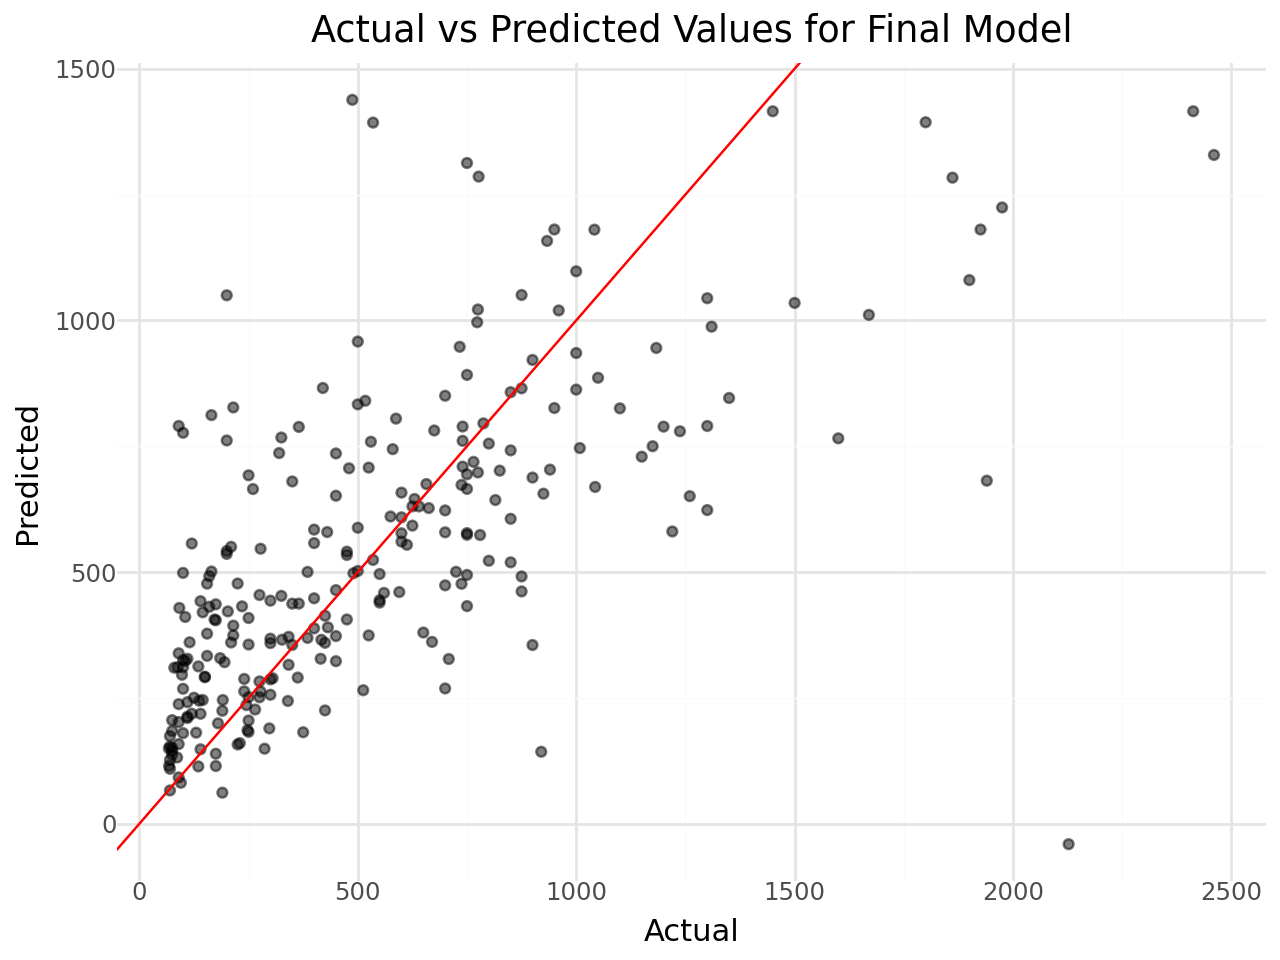

In [68]:
from plotnine import ggplot, aes, geom_point, geom_abline, labs, theme_minimal
import pandas as pd

# Selecting the five most important numerical features
X_final = X[['PutOuts', 'Hits', 'CRBI', 'CHits', 'CRuns']]

# Fit final Linear Regression pipeline on the full dataset
pipeline_lr.fit(X_final, y)
y_pred = pipeline_lr.predict(X_final)

# Convert actual and predicted values to a DataFrame for ggplot-like plotting
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred})

# Plotting with plotnine (ggplot style in Python)
plot = (
    ggplot(results_df, aes(x='Actual', y='Predicted')) +
    geom_point(alpha=0.5) +
    geom_abline(slope=1, intercept=0, color='red') +  # 45-degree reference line
    labs(title='Actual vs Predicted Values for Final Model', x='Actual', y='Predicted') +
    theme_minimal()
)

plot